In [2]:
#import pybedtools

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so

from scipy.stats import pearsonr, spearmanr
import glob

## Read Data

In [7]:
# Linux

# path = "/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/All_TFBS.csv"
# path_ens = "/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/DataSet_TFs_ENSEMBLE_IDs.txt"
# path_gtex = "/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/GTEx_GenExpr_ucsc.csv"


In [55]:
# Windows

path = r"C:\Users\julia\MyPython\BA\All_TFBS_new.csv"
path_ens = r"C:\Users\julia\MyPython\BA\Data\DataSet_TFs_ENSEMBLE_IDs.txt"
path_gtex = r"C:\Users\julia\MyPython\BA\GTEx_GenExpr_ucsc.csv"


path_homotypic = r"C:\Users\julia\MyPython\BA\Homotypic_All_TFBS_new.csv"

In [11]:
# MAC

# path = "/Users/julianmeigen/Uni/Bachelor/DATA/All_TFBS_new.csv"
# path_ens = "/Users/julianmeigen/Uni/Bachelor/DATA/DataSet_TFs_ENSEMBLE_IDs.txt"
# path_gtex = "/Users/julianmeigen/Uni/Bachelor/DATA/GTEx_GenExpr_ucsc.csv"

In [56]:
# Load Data

df_combined = pd.read_csv(path)
df_homotypic = pd.read_csv(path_homotypic)

### Functions

In [119]:
def flatten_tissues_expand_df(tfbs_df):
    tfbs_part_repeat = tfbs_df.iloc[:,:9]
    tfbs_part_flatten = tfbs_df.iloc[:,9:]
    
    repeat_df =  pd.DataFrame(np.repeat(tfbs_part_repeat.values, tfbs_part_flatten.shape[1], axis=0))
    flatten_arr = tfbs_part_flatten.to_numpy().flatten()

    tissue_repeat = np.tile(np.array(tfbs_part_flatten.columns), len(tfbs_part_repeat))
    
    repeat_df.columns = tfbs_part_repeat.columns
    repeat_df["GeneExpr"] = flatten_arr
    repeat_df["Tissue"] = tissue_repeat
    

    return repeat_df

In [120]:
def reduce_homotypic_tfbs_occurence(df):
    occur_region = df.groupby(["chr", "geneID", "tf"]).cumcount()
    df_red = df[occur_region == 0]
    return df_red

In [121]:
def remove_zero_and_transform_log2(df_flat, x="GeneExpr"):
    # remove GenExpression values of zero
    df_no_zero = df_flat.copy()[df_flat[x] != 0]
    # transform log2
    df_no_zero["log2_GeneExpr"] = np.log2(df_no_zero[x])
    return df_no_zero

In [122]:
def get_mean_expression_per_tf(df_flat, x="log2_GeneExpr"):
    return df_flat.groupby(["tf"])[x].mean()

In [123]:
def transform_expr_to_log_zero_to_nan(df, expr_iloc_start=9, expr_iloc_end=None):
    if expr_iloc_end is None:
        expr_iloc_end = len(df.columns)
    expr = df.iloc[:,expr_iloc_start:expr_iloc_end]
    replace_zero = expr.replace(0, np.NAN)
    expr_log2 = np.log2(replace_zero)
    df_new = df.copy()
    df_new.iloc[:,expr_iloc_start:expr_iloc_end] = expr_log2
    return df_new

In [124]:
### Short way to get Pearson Correlation for flat df
def get_pearson_FLAT(df_combined, col1="homotypic_count"):
    df_log_expr = transform_expr_to_log_zero_to_nan(df_combined)
    target_gene_log_flat = flatten_tissues_expand_df(df_log_expr)
    # REMOVE NAN values from Gene Expression
    target_gene_log_flat_noNAN = target_gene_log_flat[target_gene_log_flat["GeneExpr"].notna()]
    # Group Dataframe by TF and calculate Pearson Correlation for col1 und GeneExpr
    r_p_grouped_tf = target_gene_log_flat_noNAN.groupby(["tf"]).apply(lambda x: pearsonr(x[col1], x["GeneExpr"])) 
    # Generate a DataFrame to save Result in an better format
    r_p_df_flat_df = pd.DataFrame({"TFs":r_p_grouped_tf.index, "Pearson_r":[r_p_grouped_tf[i][0] for i in range(len(r_p_grouped_tf.index))], "Pearson_p":[r_p_grouped_tf[i][1] for i in range(len(r_p_grouped_tf.index))]})
    return r_p_df_flat_df

### Transform Expression

In [62]:
def transform_df_expression_to_log2(df, columns_saved=["tf"], iloc_start=9, iloc_end=None, replace_zero=True):
    # Set iloc_end to last column
    if iloc_end is None:
        iloc_end = len(df.columns)
    # CHECK if zeros should replaced by NANs before transformed to prevent -inf values
    if replace_zero:
        # New Dataframe where all 0 Expression values where replaced through NANs tot not interfere with the np.log2 transforamtion. And only the tfs and the expression values are saved.
        df_expr_log = pd.DataFrame({col_name:df[col_name] for col_name in columns_saved}).join(np.log2(df.iloc[:,iloc_start:iloc_end].replace(0, np.NAN)))
    else:
        df_expr_log = pd.DataFrame({col_name:df[col_name] for col_name in columns_saved}).join(np.log2(df.iloc[:,iloc_start:iloc_end]))
    return df_expr_log

In [35]:
# New Dataframe where all 0 Expression values where replaced through NANs tot not interfere with the np.log2 transforamtion. And only the tfs and the expression values are saved.
df_expr_log = pd.DataFrame({"tf": df_combined.tf}).join(np.log2(df_combined.iloc[:,9:].replace(0, np.NAN)))

# Group the TFs and calculate the mean, the Nans will automatically ignored.
mean_log2_expr_per_tissue = df_expr_log.groupby(["tf"]).mean()
# mean_log2_expr_per_tissue.to_csv("images/CSV_log2_mean_GenExr_diffrent_tissue_all_TFBS_ROBUST_extend_with_traget_gene_count.csv")

In [63]:
df_combined_log = transform_df_expression_to_log2(df_combined)
df_homotypic_log = transform_df_expression_to_log2(df_homotypic, columns_saved=df_homotypic.columns[:9])

## Calculate new homotypic count

In [64]:
df_homotypic_log

,chr,geneID,tf,close_tss,dist_tss,strand_orientation,homotypic_count,all_tfbs_count,all_tfbs_unique_count,Adipose - Subcutaneous,...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
0,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,-0.533242,...,0.164786,-0.048412,0.722466,1.029276,0.977463,1.071763,0.349365,1.387363,12.065248,-1.049905
1,chr1,ENSG00000143569.18,HMBOX1,9,19,T,1,12,11,5.667892,...,5.635609,5.739038,5.148527,5.299391,4.719183,6.031439,5.907852,6.035514,5.787250,4.108524
2,chr10,ENSG00000213390.10,HMBOX1,47,57,nT,1,73,55,2.902460,...,3.282885,3.192825,3.046666,4.332708,2.172488,5.034744,2.763836,3.455492,3.135042,2.953265
3,chr1,ENSG00000169241.17,HMBOX1,160,170,nT,1,115,81,4.980025,...,5.381802,5.335569,5.551208,5.715893,5.047015,4.516015,5.541948,4.922911,5.015248,4.200065
4,chr1,ENSG00000185499.16,HMBOX1,173,183,nT,1,23,20,2.388190,...,2.588565,2.746528,3.217231,1.586885,8.501837,5.176323,4.838952,4.423242,4.512859,-0.736966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704606,chr7,ENSG00000105851.10,STAT5B,-3,8,T,1,33,32,0.263034,...,-1.994241,-1.836501,1.165430,2.533563,-0.800877,2.312084,-0.187707,-0.720232,-1.207561,2.907275
704607,chr7,ENSG00000075790.10,STAT5B,124,135,nT,1,31,26,4.383359,...,3.628190,3.583760,3.162371,3.263185,3.037382,4.919340,5.226123,4.866908,4.450881,1.025029
704608,chr7,ENSG00000128590.4,STAT5B,54,69,T,1,71,59,4.663914,...,4.300490,4.084915,4.377818,4.653060,4.618239,5.744430,5.419539,5.175325,4.564988,3.105678
704609,chr7,ENSG00000198839.9,STAT5B,56,71,nT,1,122,89,3.385431,...,3.350497,3.211635,2.663345,2.647545,2.904966,2.831675,3.306262,3.350497,3.389567,1.624335


In [67]:
# Groupby tf and geneID, and thenfor all expr values in order to not lose these. But because the expresiion values should be the same,when geneID the same is, it gets same results. BUT dropna must be excluded because it will drop all rows containing NANs. 
# For each TF it will calculate the count in the same gene and save its in the column "homotypic_counts"
new_homotypic = df_homotypic_log.groupby(["tf", "geneID"] + list(df_homotypic_log.columns[9:]), dropna=False)["geneID"].count().reset_index(name="homotypic_counts")

In [68]:
new_homotypic

,tf,geneID,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,...,Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood,homotypic_counts
0,AR,ENSG00000000419.12,5.810700,5.736064,5.828327,6.015805,5.889230,5.994580,5.757823,4.100557,...,5.621466,5.517906,5.802710,5.375039,6.288912,5.937815,6.145576,5.917551,3.641546,2
1,AR,ENSG00000001460.17,1.035624,1.283922,1.074505,0.792439,0.819668,-0.142417,0.863938,1.149259,...,1.534560,1.134221,0.133564,0.548930,4.575312,1.799087,1.930548,1.608336,-1.899695,2
2,AR,ENSG00000001461.16,1.627140,2.262734,2.734222,2.024674,2.009705,0.723340,1.631803,4.177519,...,3.262132,3.028569,2.364292,2.912267,2.070733,3.981853,2.715234,2.949908,1.064193,1
3,AR,ENSG00000001497.16,4.624101,4.137504,4.046142,4.721646,4.568640,4.839456,4.752213,4.010332,...,4.538538,4.230357,4.401221,3.749534,5.775314,4.837943,5.447414,4.647890,2.155749,2
4,AR,ENSG00000001561.6,4.227279,4.151372,3.098622,4.760753,5.074034,5.184280,3.494416,3.246256,...,2.020058,3.539779,3.519793,3.606442,3.532317,3.892391,2.379621,1.921436,0.546956,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521255,ZNF740,ENSG00000275023.4,5.752749,5.599020,5.590961,6.063719,5.914804,6.037163,6.180904,4.936873,...,5.544114,5.965323,6.509062,5.618239,6.031439,7.001127,6.703904,6.044722,4.333424,1
521256,ZNF740,ENSG00000277258.4,5.449891,5.546277,5.501439,6.060588,5.667041,5.446587,5.406333,3.589763,...,4.906891,4.908333,5.214513,4.821710,4.632850,6.280956,6.319582,5.666473,-1.380822,1
521257,ZNF740,ENSG00000278615.4,4.188243,4.306700,4.357904,4.557655,4.565293,4.442943,4.361066,3.607626,...,4.412104,4.491212,4.695994,4.264536,4.959770,4.475733,4.404971,4.310340,3.716991,1
521258,ZNF740,ENSG00000280670.2,0.911500,0.697774,1.412511,1.773996,1.181421,1.153157,2.101314,2.369606,...,1.332278,1.493135,2.300124,1.375178,3.210233,2.491597,2.278282,1.526069,-0.309359,1


In [90]:
info_df = new_homotypic[["tf", "geneID", "homotypic_counts"]]
expr_df = new_homotypic.iloc[:,2:-1]

In [116]:
tissue_dependent_df = pd.concat([info_df, expr_df], axis=1)

# Tissue independend

## Get Mean Expression

In [91]:
mean_expr_df = expr_df.mean(axis=1)

In [100]:
mean_expr_df.to_frame(name="mean_expr")

,mean_expr
0,5.395399
1,1.182332
2,2.997136
3,4.455222
4,3.383798
...,...
521255,5.672450
521256,4.852081
521257,4.170406
521258,1.730440


In [111]:
tissue_independent_df = pd.concat([info_df, mean_expr_df.to_frame(name="mean_expr")], axis=1)
tissue_independent_df

,tf,geneID,homotypic_counts,mean_expr
0,AR,ENSG00000000419.12,2,5.395399
1,AR,ENSG00000001460.17,2,1.182332
2,AR,ENSG00000001461.16,1,2.997136
3,AR,ENSG00000001497.16,2,4.455222
4,AR,ENSG00000001561.6,1,3.383798
...,...,...,...,...
521255,ZNF740,ENSG00000275023.4,1,5.672450
521256,ZNF740,ENSG00000277258.4,1,4.852081
521257,ZNF740,ENSG00000278615.4,1,4.170406
521258,ZNF740,ENSG00000280670.2,1,1.730440


In [113]:
# To calcualte pearson every Gene with a mean expr of NAN must be filtered ... 
tissue_independent_df = tissue_independent_df.dropna()
tissue_independent_df

,tf,geneID,homotypic_counts,mean_expr
0,AR,ENSG00000000419.12,2,5.395399
1,AR,ENSG00000001460.17,2,1.182332
2,AR,ENSG00000001461.16,1,2.997136
3,AR,ENSG00000001497.16,2,4.455222
4,AR,ENSG00000001561.6,1,3.383798
...,...,...,...,...
521255,ZNF740,ENSG00000275023.4,1,5.672450
521256,ZNF740,ENSG00000277258.4,1,4.852081
521257,ZNF740,ENSG00000278615.4,1,4.170406
521258,ZNF740,ENSG00000280670.2,1,1.730440


## Get Pearson for each TF

### Using all expr values as datapoints -- OLD functions

In [128]:
### IMPORT from Geneexpr_seaborn

def transform_expr_to_log_zero_to_nan(df, expr_iloc_start=9, expr_iloc_end=None):
    if expr_iloc_end is None:
        expr_iloc_end = len(df.columns)
    expr = df.iloc[:,expr_iloc_start:expr_iloc_end]
    replace_zero = expr.replace(0, np.NAN)
    expr_log2 = np.log2(replace_zero)
    df_new = df.copy()
    df_new.iloc[:,expr_iloc_start:expr_iloc_end] = expr_log2
    return df_new

def get_pearson_FLAT(df_combined, col1="homotypic_count"):
    df_log_expr = transform_expr_to_log_zero_to_nan(df_combined)
    target_gene_log_flat = flatten_tissues_expand_df(df_log_expr)
    # REMOVE NAN values from Gene Expression
    target_gene_log_flat_noNAN = target_gene_log_flat[target_gene_log_flat["GeneExpr"].notna()]
    # Group Dataframe by TF and calculate Pearson Correlation for col1 und GeneExpr
    r_p_grouped_tf = target_gene_log_flat_noNAN.groupby(["tf"]).apply(lambda x: pearsonr(x[col1], x["GeneExpr"])) 
    # Generate a DataFrame to save Result in an better format
    r_p_df_flat_df = pd.DataFrame({"TFs":r_p_grouped_tf.index, "Pearson_r":[r_p_grouped_tf[i][0] for i in range(len(r_p_grouped_tf.index))], "Pearson_p":[r_p_grouped_tf[i][1] for i in range(len(r_p_grouped_tf.index))]})
    return r_p_df_flat_df

In [129]:
tissue_dependent_df

,tf,geneID,homotypic_counts,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
0,AR,ENSG00000000419.12,2,5.810700,5.736064,5.828327,6.015805,5.889230,5.994580,5.757823,...,5.668743,5.621466,5.517906,5.802710,5.375039,6.288912,5.937815,6.145576,5.917551,3.641546
1,AR,ENSG00000001460.17,2,1.035624,1.283922,1.074505,0.792439,0.819668,-0.142417,0.863938,...,1.459432,1.534560,1.134221,0.133564,0.548930,4.575312,1.799087,1.930548,1.608336,-1.899695
2,AR,ENSG00000001461.16,1,1.627140,2.262734,2.734222,2.024674,2.009705,0.723340,1.631803,...,3.065572,3.262132,3.028569,2.364292,2.912267,2.070733,3.981853,2.715234,2.949908,1.064193
3,AR,ENSG00000001497.16,2,4.624101,4.137504,4.046142,4.721646,4.568640,4.839456,4.752213,...,4.398487,4.538538,4.230357,4.401221,3.749534,5.775314,4.837943,5.447414,4.647890,2.155749
4,AR,ENSG00000001561.6,1,4.227279,4.151372,3.098622,4.760753,5.074034,5.184280,3.494416,...,1.504366,2.020058,3.539779,3.519793,3.606442,3.532317,3.892391,2.379621,1.921436,0.546956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521255,ZNF740,ENSG00000275023.4,1,5.752749,5.599020,5.590961,6.063719,5.914804,6.037163,6.180904,...,5.539159,5.544114,5.965323,6.509062,5.618239,6.031439,7.001127,6.703904,6.044722,4.333424
521256,ZNF740,ENSG00000277258.4,1,5.449891,5.546277,5.501439,6.060588,5.667041,5.446587,5.406333,...,4.697941,4.906891,4.908333,5.214513,4.821710,4.632850,6.280956,6.319582,5.666473,-1.380822
521257,ZNF740,ENSG00000278615.4,1,4.188243,4.306700,4.357904,4.557655,4.565293,4.442943,4.361066,...,4.438626,4.412104,4.491212,4.695994,4.264536,4.959770,4.475733,4.404971,4.310340,3.716991
521258,ZNF740,ENSG00000280670.2,1,0.911500,0.697774,1.412511,1.773996,1.181421,1.153157,2.101314,...,1.027862,1.332278,1.493135,2.300124,1.375178,3.210233,2.491597,2.278282,1.526069,-0.309359


In [206]:
pearson_per_tf = get_pearson_FLAT(tissue_dependent_df, col1="homotypic_counts")

C:\Users\julia\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)
C:\Users\julia\AppData\Local\Temp\ipykernel_24616\3232035925.py:19: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_p_grouped_tf = target_gene_log_flat_noNAN.groupby(["tf"]).apply(lambda x: pearsonr(x[col1], x["GeneExpr"]))
C:\Users\julia\AppData\Local\Temp\ipykernel_24616\3232035925.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r_p_grouped_tf = target_gene_log_flat_noNAN.groupby(["tf"]).apply(lambda x: pearsonr(x[col1], x["GeneExpr"]))
C:\Users\julia\AppData\Local\Temp\ipyk

In [134]:
pearson_per_tf

,TFs,Pearson_r,Pearson_p
0,AR,0.020358,1.662917e-27
1,ARNT,0.016192,5.603857e-10
2,ARNTL,-0.019172,2.086050e-01
3,ASCL1,0.006172,1.633588e-01
4,ATF2,0.054764,1.021459e-20
...,...,...,...
261,YY2,0.013938,2.031154e-02
262,ZFX,0.029629,4.029511e-09
263,ZNF143,0.018228,6.054936e-12
264,ZNF263,NaN,NaN


### Using the mean for each gene

In [137]:
tissue_independent_df

,tf,geneID,homotypic_counts,mean_expr
0,AR,ENSG00000000419.12,2,5.395399
1,AR,ENSG00000001460.17,2,1.182332
2,AR,ENSG00000001461.16,1,2.997136
3,AR,ENSG00000001497.16,2,4.455222
4,AR,ENSG00000001561.6,1,3.383798
...,...,...,...,...
521255,ZNF740,ENSG00000275023.4,1,5.672450
521256,ZNF740,ENSG00000277258.4,1,4.852081
521257,ZNF740,ENSG00000278615.4,1,4.170406
521258,ZNF740,ENSG00000280670.2,1,1.730440


In [152]:
def pearson_lambda(row, col1, col2):
    if len(row[col1].unique()) != 1:
        return pearsonr(row[col1], row[col2])
    else:
        # print(f"No pearson correlation could be computed.")
        return np.NAN

In [178]:
pearson_per_tf_grouped= tissue_independent_df.groupby(["tf"])[["homotypic_counts", "mean_expr"]].apply(lambda x: pearson_lambda(row=x ,col1="homotypic_counts", col2="mean_expr"))


In [179]:
pearson_per_tf_grouped

tf
AR        (0.05507258640755595, 4.241877962024166e-06)
ARNT       (0.029060363903897556, 0.08512672487037372)
ARNTL      (-0.004260580150141847, 0.9667883870983113)
ASCL1       (0.017177113165527516, 0.5324701300945245)
ATF2        (0.08116885830014911, 0.02683410112664263)
                              ...                     
YY2        (0.027712173994219318, 0.48887106405370034)
ZFX         (0.06388936417606719, 0.05773002461007007)
ZNF143     (0.04821460629129185, 0.004962036607535861)
ZNF263                                             NaN
ZNF740                                             NaN
Length: 266, dtype: object

In [186]:
def pearson_gropued_to_df(df_grouped):
    # Get TFs with NAN
    filtered_tf = df_grouped.index[df_grouped.isna()]
    
    # Dropna
    df_nona = df_grouped.dropna()
    # new df
    pearson_df = pd.DataFrame({"TFs":df_nona.index, "Pearson_r":[df_nona[i][0] for i in range(len(df_nona.index))], "Pearson_p":[df_nona[i][1] for i in range(len(df_nona.index))]})
    return pearson_df, filtered_tf

In [207]:
pearson_per_tf_mean, filtered_tf= pearson_gropued_to_df(pearson_per_tf_grouped)

C:\Users\julia\AppData\Local\Temp\ipykernel_24616\1267982859.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pearson_df = pd.DataFrame({"TFs":df_nona.index, "Pearson_r":[df_nona[i][0] for i in range(len(df_nona.index))], "Pearson_p":[df_nona[i][1] for i in range(len(df_nona.index))]})


In [268]:
filtered_tf

Index(['BATF3', 'BCL6B', 'CEBPD', 'E2F7', 'E2F8', 'EGR3', 'ELF5', 'ETV5',
       'FOXA3', 'FOXJ2', 'FOXK1', 'GFI1', 'GLIS2', 'GLIS3', 'HIC1', 'HINFP',
       'HOXA9', 'HSF2', 'KLF12', 'KLF15', 'KLF16', 'LHX2', 'MECOM', 'MEF2C',
       'MEF2D', 'MEIS2', 'NFYC', 'NKX3-1', 'NR4A1', 'NR5A1', 'NR5A2', 'PAX6',
       'PBX1', 'PLAG1', 'POU2F1', 'PRDM4', 'RFX2', 'RFX3', 'RUNX3', 'RXRB',
       'SCRT1', 'SCRT2', 'SOX10', 'SOX4', 'SOX6', 'SOX9', 'SP3', 'SP4',
       'SPDEF', 'STAT4', 'STAT6', 'TCF7L1', 'TEAD3', 'THRB', 'ZNF263',
       'ZNF740'],
      dtype='object', name='tf')

In [208]:
pearson_per_tf_mean

,TFs,Pearson_r,Pearson_p
0,AR,0.055073,0.000004
1,ARNT,0.029060,0.085127
2,ARNTL,-0.004261,0.966788
3,ASCL1,0.017177,0.532470
4,ATF2,0.081169,0.026834
...,...,...,...
205,XBP1,0.009843,0.805545
206,YY1,0.048546,0.000610
207,YY2,0.027712,0.488871
208,ZFX,0.063889,0.057730


In [213]:
pearson_per_tf.dropna()

,TFs,Pearson_r,Pearson_p
0,AR,0.020358,1.662917e-27
1,ARNT,0.016192,5.603857e-10
2,ARNTL,-0.019172,2.086050e-01
3,ASCL1,0.006172,1.633588e-01
4,ATF2,0.054764,1.021459e-20
...,...,...,...
259,XBP1,0.012537,3.226153e-02
260,YY1,0.017119,8.317910e-15
261,YY2,0.013938,2.031154e-02
262,ZFX,0.029629,4.029511e-09


### Filter p_values

In [290]:
filterd_by_p_mean = np.array((pearson_per_tf_mean[pearson_per_tf_mean.Pearson_p >= 0.05].TFs))
filterd_by_p_mean

array(['ARNT', 'ARNTL', 'ASCL1', 'ATF4', 'ATF7', 'BACH1', 'BACH2', 'BATF',
       'BCL6', 'BHLHE22', 'CDX2', 'CEBPA', 'CEBPG', 'CLOCK', 'CUX1',
       'DUX4', 'EBF1', 'EBF3', 'EGR2', 'ELF4', 'ELK1', 'EOMES', 'ERF',
       'ESR2', 'ESRRA', 'ETV1', 'ETV4', 'ETV6', 'FOS', 'FOSL1', 'FOSL2',
       'FOXA1', 'FOXA2', 'FOXK2', 'FOXP1', 'GATA2', 'GATA3', 'GATA4',
       'GATA6', 'GFI1B', 'GLIS1', 'GRHL2', 'HAND2', 'HLF', 'HMBOX1',
       'HNF1B', 'HNF4G', 'HOXB13', 'HSF1', 'IRF1', 'IRF2', 'IRF3', 'IRF4',
       'ISL1', 'JUND', 'KLF1', 'KLF11', 'KLF9', 'LEF1', 'LHX9', 'MAF',
       'MAFB', 'MAFF', 'MEF2A', 'MEIS1', 'MGA', 'MLX', 'MNT', 'MYBL2',
       'MYF5', 'MYOD1', 'MYOG', 'NFIA', 'NFIB', 'NFIL3', 'NFKB1', 'NFKB2',
       'NFYA', 'NFYB', 'NKX2-5', 'NR1H4', 'NR2C1', 'NR2F1', 'NR2F2',
       'NR2F6', 'ONECUT1', 'ONECUT2', 'OTX2', 'PBX2', 'PBX3', 'PDX1',
       'PHOX2B', 'PKNOX1', 'POU2F2', 'POU5F1', 'PRDM1', 'RARA', 'RARG',
       'RBPJ', 'REL', 'RELB', 'RFX1', 'RFX5', 'RUNX2', 'SIX1', 'SIX2',

In [291]:
pearson_valid_tf =  pearson_per_tf[pearson_per_tf.Pearson_p < 0.05]
pearson_valid_tf_mean =  pearson_per_tf_mean[pearson_per_tf_mean.Pearson_p < 0.05]

In [316]:
pearson_valid_tf_mean = pearson_valid_tf_mean.set_index("TFs")


### Sort by abs peason_r

In [318]:
pearson_valid_tf_mean_sort = pearson_valid_tf_mean.sort_values(by="Pearson_r", key=lambda x:np.abs(x), ascending=False)
pearson_valid_tf_sort = pearson_valid_tf.sort_values(by="Pearson_r", key=lambda x:np.abs(x), ascending=False)

## Plot

In [338]:
pearson_plot = pearson_valid_tf_mean_sort

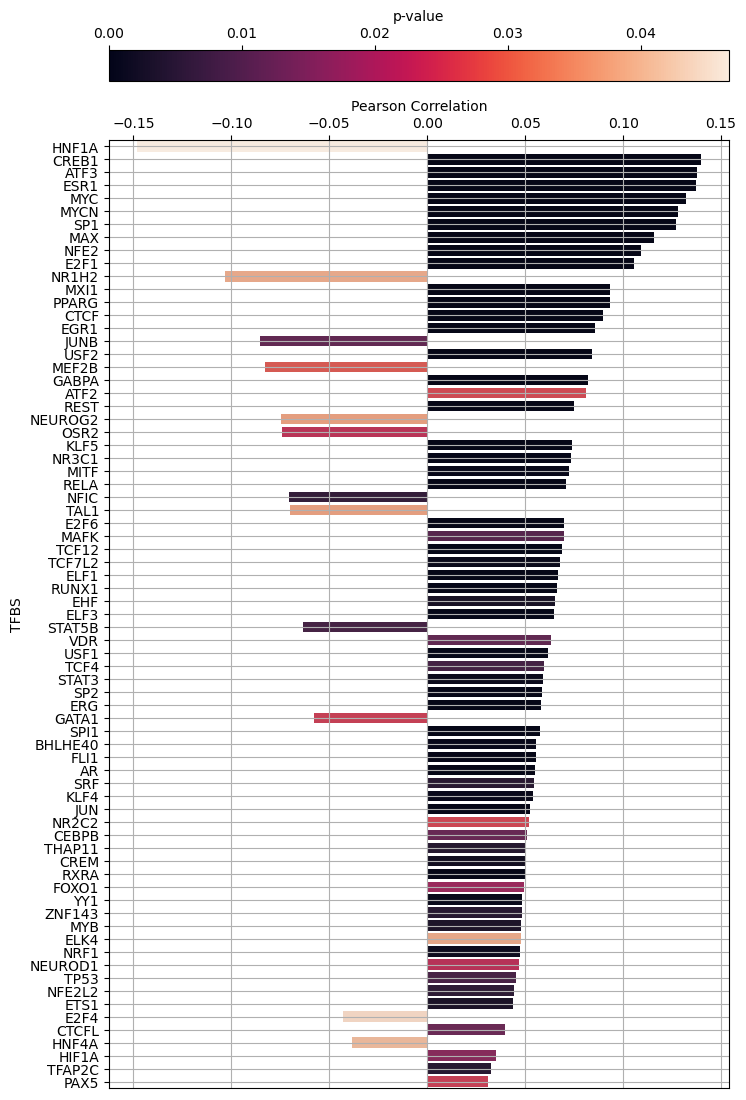

In [341]:
fig, ax = plt.subplots(figsize=(8,15))

norm = plt.Normalize(pearson_plot["Pearson_p"].min(), pearson_plot["Pearson_p"].max())
sm = plt.cm.ScalarMappable(cmap="rocket", norm=norm)


sns.barplot(pearson_plot, x="Pearson_r", y="TFs",hue="Pearson_p", palette="rocket",dodge=False)


ax.set_ylabel('TFBS')

ax.xaxis.tick_top()
ax.set_xlabel('Pearson Correlation')
ax.xaxis.set_label_position("top")


ax.xaxis.grid(True)
ax.yaxis.grid(True)

ax.get_legend().remove()

plt.subplots_adjust(top=0.9)
cbar = ax.figure.colorbar(sm, ax=ax, orientation= "horizontal", location="top", )
cbar.set_label("p-value")

# fig.savefig("images_BA/homotypic_FLAT_Pearson_Bar.pdf")

### TABLES

In [ ]:
# print(pearson_valid_tf_mean.set_index("TFs").to_latex(longtable=True, formatters=["{:,.4f}".format, "{:,.1e}".format]))

In [320]:
neg = pearson_valid_tf_mean_sort[pearson_valid_tf_mean_sort.Pearson_r < 0 ]

In [332]:
# Alle 12 negativ Korrelierten:
print(neg.to_latex(formatters=["{:,.4f}".format, "{:,.1e}".format]))

\begin{tabular}{lrr}
\toprule
 & Pearson_r & Pearson_p \\
TFs &  &  \\
\midrule
HNF1A & -0.1481 & 4.7e-02 \\
NR1H2 & -0.1034 & 3.8e-02 \\
JUNB & -0.0853 & 1.3e-02 \\
MEF2B & -0.0829 & 2.9e-02 \\
NEUROG2 & -0.0745 & 3.7e-02 \\
OSR2 & -0.0744 & 2.4e-02 \\
NFIC & -0.0707 & 6.7e-03 \\
TAL1 & -0.0702 & 3.7e-02 \\
STAT5B & -0.0637 & 9.2e-03 \\
GATA1 & -0.0580 & 2.6e-02 \\
E2F4 & -0.0431 & 4.4e-02 \\
HNF4A & -0.0384 & 4.0e-02 \\
\bottomrule
\end{tabular}



In [323]:
pos = pearson_valid_tf_mean_sort[pearson_valid_tf_mean_sort.Pearson_r > 0 ]

In [331]:
# Die 12 besten Positiv korrelierten
print(pos.iloc[:12].to_latex(formatters=["{:,.4f}".format, "{:,.1e}".format]))

\begin{tabular}{lrr}
\toprule
 & Pearson_r & Pearson_p \\
TFs &  &  \\
\midrule
CREB1 & 0.1396 & 1.2e-28 \\
ATF3 & 0.1375 & 2.7e-14 \\
ESR1 & 0.1370 & 1.8e-39 \\
MYC & 0.1319 & 1.5e-37 \\
MYCN & 0.1278 & 2.4e-24 \\
SP1 & 0.1270 & 8.9e-33 \\
MAX & 0.1158 & 1.6e-24 \\
NFE2 & 0.1089 & 2.9e-05 \\
E2F1 & 0.1053 & 1.3e-21 \\
MXI1 & 0.0934 & 4.4e-11 \\
PPARG & 0.0932 & 3.2e-09 \\
CTCF & 0.0897 & 5.8e-17 \\
\bottomrule
\end{tabular}



# Tissue dependent

In [245]:
def get_pearson_all_tissues(df):
    tfs = df["tf"].unique()
    tissues = np.array(df.columns[3:])
    
    # initialize Array with shape (0,54), This is important to vstack the 1D-Arrays for every tf, to genereate a 2D-array.
    r_all_tf = np.zeros([0,len(tissues)])
    p_all_tf = np.zeros([0,len(tissues)])

    tfs_lst = []
    for tf in tfs:
        df_tf = df[df["tf"] == tf]
        if len(df_tf) > 1:
            tfs_lst.append(tf)

            tfbs_counts = np.array(df_tf["homotypic_counts"])
            expr = np.array(df_tf.iloc[:,3:])

            r_all_tissue = np.array([])
            p_all_tissue = np.array([])
            for tissue in range(len(tissues)):
                tissue_expr = expr[:,tissue]
                
                # REMOVE NANS for both Arrays
                mask = ~np.isnan(tissue_expr)
                tissue_expr_notNAN = tissue_expr[mask]
                tfbs_counts_notNAN = tfbs_counts[mask]
                

                r, p = pearsonr(tfbs_counts_notNAN, tissue_expr_notNAN)
                r_all_tissue = np.append(r_all_tissue, r)
                p_all_tissue = np.append(p_all_tissue, p)
            # Appand r and p for single tfs into one big 2d array
            r_all_tf = np.vstack((r_all_tf, r_all_tissue))
            p_all_tf = np.vstack((p_all_tf, p_all_tissue))

        else:
            print(f"{tf} has only 1 entry. No Correlation could be calculated")
        # Add columns to DataFrame and set index to tf names
        r_df = pd.DataFrame(r_all_tf, columns=tissues)
        r_df.index = tfs_lst
        p_df = pd.DataFrame(p_all_tf, columns=tissues)
        p_df.index = tfs_lst       
        
    return r_df, p_df

In [244]:
tissue_dependent_df

,tf,geneID,homotypic_counts,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
0,AR,ENSG00000000419.12,2,5.810700,5.736064,5.828327,6.015805,5.889230,5.994580,5.757823,...,5.668743,5.621466,5.517906,5.802710,5.375039,6.288912,5.937815,6.145576,5.917551,3.641546
1,AR,ENSG00000001460.17,2,1.035624,1.283922,1.074505,0.792439,0.819668,-0.142417,0.863938,...,1.459432,1.534560,1.134221,0.133564,0.548930,4.575312,1.799087,1.930548,1.608336,-1.899695
2,AR,ENSG00000001461.16,1,1.627140,2.262734,2.734222,2.024674,2.009705,0.723340,1.631803,...,3.065572,3.262132,3.028569,2.364292,2.912267,2.070733,3.981853,2.715234,2.949908,1.064193
3,AR,ENSG00000001497.16,2,4.624101,4.137504,4.046142,4.721646,4.568640,4.839456,4.752213,...,4.398487,4.538538,4.230357,4.401221,3.749534,5.775314,4.837943,5.447414,4.647890,2.155749
4,AR,ENSG00000001561.6,1,4.227279,4.151372,3.098622,4.760753,5.074034,5.184280,3.494416,...,1.504366,2.020058,3.539779,3.519793,3.606442,3.532317,3.892391,2.379621,1.921436,0.546956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521255,ZNF740,ENSG00000275023.4,1,5.752749,5.599020,5.590961,6.063719,5.914804,6.037163,6.180904,...,5.539159,5.544114,5.965323,6.509062,5.618239,6.031439,7.001127,6.703904,6.044722,4.333424
521256,ZNF740,ENSG00000277258.4,1,5.449891,5.546277,5.501439,6.060588,5.667041,5.446587,5.406333,...,4.697941,4.906891,4.908333,5.214513,4.821710,4.632850,6.280956,6.319582,5.666473,-1.380822
521257,ZNF740,ENSG00000278615.4,1,4.188243,4.306700,4.357904,4.557655,4.565293,4.442943,4.361066,...,4.438626,4.412104,4.491212,4.695994,4.264536,4.959770,4.475733,4.404971,4.310340,3.716991
521258,ZNF740,ENSG00000280670.2,1,0.911500,0.697774,1.412511,1.773996,1.181421,1.153157,2.101314,...,1.027862,1.332278,1.493135,2.300124,1.375178,3.210233,2.491597,2.278282,1.526069,-0.309359


In [246]:
r_df, p_df = get_pearson_all_tissues(tissue_dependent_df)

C:\Users\julia\AppData\Local\Temp\ipykernel_24616\2811398673.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(tfbs_counts_notNAN, tissue_expr_notNAN)
C:\Users\julia\AppData\Local\Temp\ipykernel_24616\2811398673.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(tfbs_counts_notNAN, tissue_expr_notNAN)
C:\Users\julia\AppData\Local\Temp\ipykernel_24616\2811398673.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(tfbs_counts_notNAN, tissue_expr_notNAN)
C:\Users\julia\AppData\Local\Temp\ipykernel_24616\2811398673.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(tfbs_counts_notNAN, tissue_expr_notNAN)
C:\Users\julia\AppData\Local\Temp\ipykernel_24616\2811398673.py:29: ConstantInputWarning: An input array is constant; th

NR5A1 has only 1 entry. No Correlation could be calculated


C:\Users\julia\AppData\Local\Temp\ipykernel_24616\2811398673.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(tfbs_counts_notNAN, tissue_expr_notNAN)
C:\Users\julia\AppData\Local\Temp\ipykernel_24616\2811398673.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(tfbs_counts_notNAN, tissue_expr_notNAN)
C:\Users\julia\AppData\Local\Temp\ipykernel_24616\2811398673.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(tfbs_counts_notNAN, tissue_expr_notNAN)
C:\Users\julia\AppData\Local\Temp\ipykernel_24616\2811398673.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(tfbs_counts_notNAN, tissue_expr_notNAN)
C:\Users\julia\AppData\Local\Temp\ipykernel_24616\2811398673.py:29: ConstantInputWarning: An input array is constant; th

In [376]:
# Which TFBS have only one TFBS per Promotor?
np.array(sorted(r_df[np.all(r_df.isna(), axis=1)].index.to_numpy()))

array(['BATF3', 'BCL6B', 'CEBPD', 'E2F7', 'E2F8', 'EGR3', 'ELF5', 'ETV5',
       'FOXA3', 'FOXJ2', 'FOXK1', 'GFI1', 'GLIS2', 'GLIS3', 'HIC1',
       'HINFP', 'HOXA9', 'HSF2', 'KLF12', 'KLF15', 'KLF16', 'LHX2',
       'MECOM', 'MEF2C', 'MEF2D', 'MEIS2', 'NFYC', 'NKX3-1', 'NR4A1',
       'NR5A2', 'PAX6', 'PBX1', 'PLAG1', 'POU2F1', 'PRDM4', 'RFX2',
       'RFX3', 'RUNX3', 'RXRB', 'SCRT1', 'SCRT2', 'SOX10', 'SOX4', 'SOX6',
       'SOX9', 'SP3', 'SP4', 'SPDEF', 'STAT4', 'STAT6', 'TCF7L1', 'TEAD3',
       'THRB', 'ZNF263', 'ZNF740'], dtype='<U6')

In [408]:
# Sort both DataFrames based on the sum of the correlation coefficient
r_df_s = r_df.reindex(abs(r_df.sum(axis=1)).sort_values(ascending=False).index)
p_df_s = p_df.reindex(abs(r_df.sum(axis=1)).sort_values(ascending=False).index)

#  and remove TFs with only NANs.
r_df_s = r_df_s[~np.all(r_df_s.isna(), axis=1)]
p_df_s = p_df_s[~np.all(p_df_s.isna(), axis=1)]

In [425]:
# Filter r_df using p-value from p_df
r_df_filtered_by_p_value = r_df_s[p_df_s<0.05]
# np.array(sorted(r_df_filtered_by_p_value[np.all(r_df_filtered_by_p_value.isna(), axis=1)].index))

In [538]:
# OPTIONAL to filter NAN rows and sort TFS
r_df_filtered_by_p_value_remove_nan_rows = r_df_filtered_by_p_value[~np.all(r_df_filtered_by_p_value.isna(), axis=1)]
r_df_filtered_by_p_value_remove_nan_rows_sort_by_mean = r_df_filtered_by_p_value_remove_nan_rows.reindex(abs(r_df_filtered_by_p_value_remove_nan_rows.mean(axis=1, skipna=True)).sort_values(ascending=False).index)

In [566]:
# pos = r_df_filtered_by_p_value_remove_nan_rows.sort_values(by="Pearson_p")
pos_idx = r_df_filtered_by_p_value_remove_nan_rows.max(axis=1).sort_values(ascending=False).iloc[:12].index
neg_idx = r_df_filtered_by_p_value_remove_nan_rows.min(axis=1).sort_values(ascending=True).iloc[:12].index

In [567]:
neg = r_df_filtered_by_p_value_remove_nan_rows.loc[neg_idx]
pos = r_df_filtered_by_p_value_remove_nan_rows.loc[pos_idx]

## Plot

In [570]:
plot_df = pos

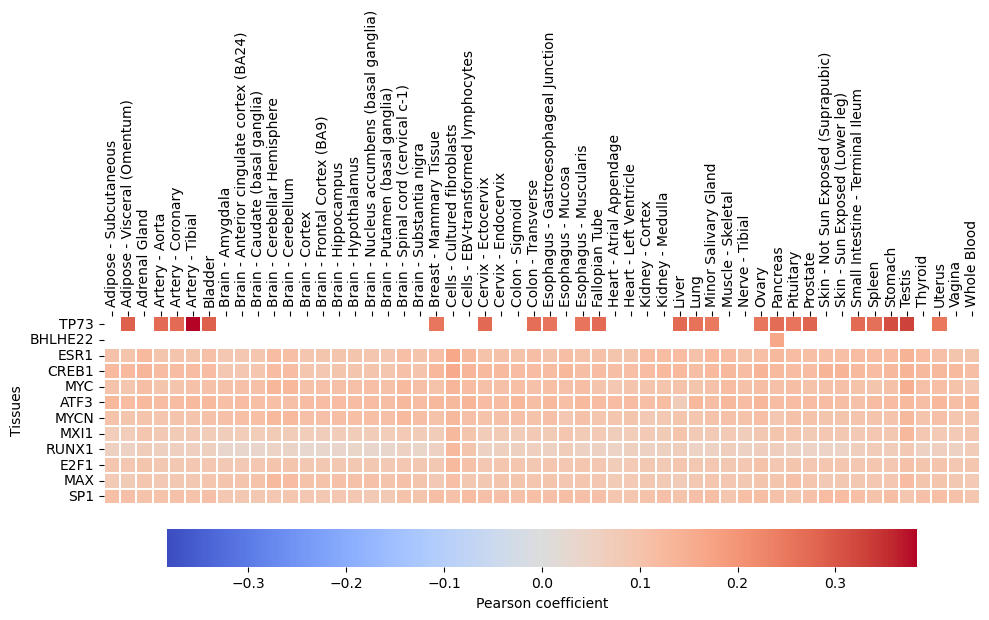

In [571]:
value_max = max(max(abs(plot_df.max())), max(abs(plot_df.min())))
value_min = -value_max

# asp = plot_df.shape[0] /float(plot_df.shape[1])
# figw = 12
# figh = figw*asp

fig, ax = plt.subplots(figsize=(10, 6))
heatmap = sns.heatmap(plot_df, cmap='coolwarm', fmt=".2f", linewidths=0.01,vmin=value_min, vmax=value_max, cbar_kws={"orientation": "horizontal", "location":"bottom", "label":"Pearson coefficient", "pad":0.1})
#plt.title('Genexpression in different tissues')
plt.xlabel('TFBS')
plt.ylabel('Tissues')

ax.xaxis.tick_top()
ax.set_xlabel("")
ax.xaxis.set_label_position("top")
plt.xticks(rotation=90)


plt.tight_layout()
# fig.savefig("images/Pearson_filtered_remove_p_sort_by_mean_withoutNAN.png")
plt.show()

## Heatmaps

In [437]:
plot_df = r_df_filtered_by_p_value

In [455]:
## Specific TFs
tf_most_target_genes = ['MYC', 'ESR1', 'SP1', 'CTCF', 'E2F1', 'MAX', 'RUNX1', 'TFAP2C', 'AR', 'KLF5', 'JUN', 'RELA', 'MYCN', 'CREB1', 'E2F6', 'SP2']

tf_smallest_expr = ["NR1H4", "SOX10", "HNF1B", "HNF1A", "ISL1"]
tf_biggest_expr = ["NR5A1", "XBP1", "TFEB", "HSF2", "NR2C1"]

"['NR5A1', 'HSF2', 'SOX10'] not in index"
"NR2C1 , TFEB, XBP1"

tf_smallest_expr = ["NR1H4", "HNF1B", "HNF1A", "ISL1"]
#tf_biggest_expr = ["XBP1", "TFEB", "NR2C1"]

In [429]:
most_df_plot = plot_df.loc[tf_most_target_genes]
# most_id_count_plot = id_count.loc[tf_most_target_genes]

In [457]:
extreme_df_plot = plot_df.loc[tf_smallest_expr]
# extreme_id_count_plot = id_count.loc[tf_biggest_expr+tf_smallest_expr]

In [451]:
extreme_df_plot.min().min()

-0.4907613374613517

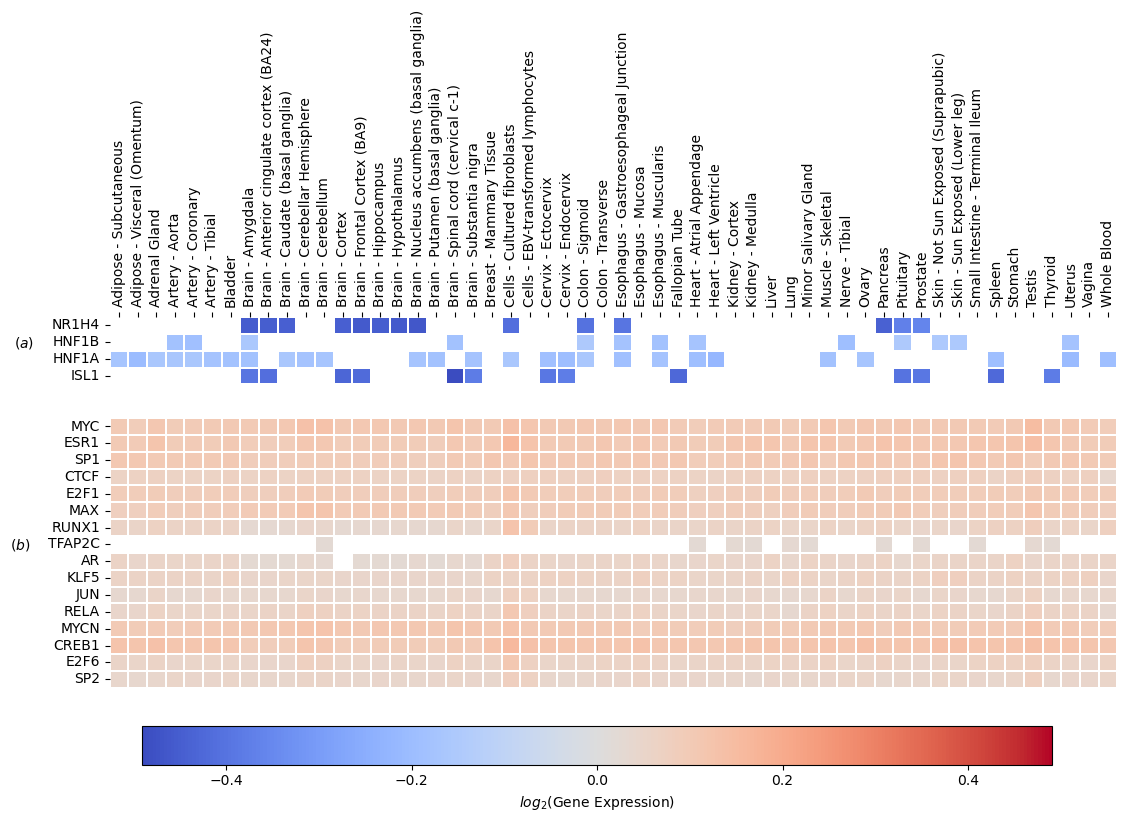

In [463]:
value_min = plot_df.min().min()
value_max = -value_min

my_cmap = plt.get_cmap("coolwarm").copy()
norm = mpl.colors.Normalize(vmin= value_min, vmax= value_max)

asp = (extreme_df_plot.shape[0] + most_df_plot.shape[0]) /float(extreme_df_plot.shape[1])
figw = 13
figh = figw*asp


gridspec_kw = {"height_ratios":[len(extreme_df_plot), len(most_df_plot)], "width_ratios" : [54]}
heatmapkws = dict(square=False, cbar=False,  cmap=my_cmap, fmt=".2f", linewidths=0.01, vmin= value_min, vmax= value_max, robust=True)


fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(figw, figh), gridspec_kw=gridspec_kw)

# left = 0.07; right=0.87
# bottom = 0.1; top = 0.9

plt.subplots_adjust(wspace=0.06, hspace=0.2)



# sns.heatmap(mean_log2_expr_per_tissue_copy, cmap=my_cmap, fmt=".2f", linewidths=0.01, cbar_kws={"orientation": "horizontal", "location":"top", "label":"$log_2$(Gene Expression)", "extend":"both"}, vmin= value_min, vmax= value_max, robust=True)
# Mean over all tissues - row
# sns.heatmap(extreme_df_plot.iloc[:1,:54], ax=axes[0,0], xticklabels=True, yticklabels=True,  **heatmapkws)

# Mean over all Target genes - column
# sns.heatmap(extreme_df_plot.iloc[1:,54:], ax=axes[0], xticklabels=True, yticklabels=True,  **heatmapkws)
# Normal heatmap
sns.heatmap(extreme_df_plot, ax=axes[0], xticklabels=True, yticklabels=True,  **heatmapkws)
# mean gene expr over all
# sns.heatmap(extreme_df_plot.iloc[:1,54:], ax=axes[0,1], xticklabels=True, yticklabels=True,  **heatmapkws)


# PLOT 2

# Mean over all Target genes - column
# sns.heatmap(most_df_plot.iloc[1:,54:], ax=axes[2,1], xticklabels=True, yticklabels=True,  **heatmapkws)
# Normal heatmap
sns.heatmap(most_df_plot, ax=axes[1], xticklabels=True, yticklabels=True,  **heatmapkws)



# axes[0,0].set_xlabel('Tissues')
axes[0].set_ylabel('$(a)$', rotation=0, labelpad = 20)

# Main Heatmap, x ticks entfernen, y-ticks lassen
axes[0].tick_params(axis="x",top=True,labeltop=True, labelbottom=False, bottom=False, labelrotation=90)
axes[0].tick_params(axis="y", labelrotation=0)

# axes[0].set_xticklabels([])
# axes[0].set_xticks([])



axes[1].set_ylabel('$(b)$', rotation=0, labelpad = 20)
# Main Heatmap, x ticks entfernen, y-ticks lassen
axes[1].set_xticklabels([])
axes[1].set_xticks([])




# Colorbar
# cax = fig.add_axes([0.12, 0.9, 0.8, 0.01])
cax = fig.add_axes([0.15,-.05,0.7,0.08])
sm = mpl.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cax, orientation="horizontal", location="bottom", label="$log_2$(Gene Expression)")
# plt.tight_layout()
# plt.savefig(r"images_BA/heat_homotypic_pearson_extreme_and_most.pdf", bbox_inches = 'tight')

# OLD

## Read Data

In [7]:
#path = "/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/All_TFBS.csv"
path = r"C:\Users\julia\MyPython\BA\All_TFBS.csv"
df_combined = pd.read_csv(path)
df_combined = df_combined[df_combined["chr"] != "chrM"]

Flatten Genexpression

In [12]:
def flatten_tissues_expand_df(tfbs_df):
    tfbs_part_repeat = tfbs_df.iloc[:,:9]
    tfbs_part_flatten = tfbs_df.iloc[:,9:]
    
    repeat_df =  pd.DataFrame(np.repeat(tfbs_part_repeat.values, tfbs_part_flatten.shape[1], axis=0))
    flatten_arr = tfbs_part_flatten.to_numpy().flatten()

    tissue_repeat = np.tile(np.array(tfbs_part_flatten.columns), len(tfbs_part_repeat))
    
    repeat_df.columns = tfbs_part_repeat.columns
    repeat_df["GeneExpr"] = flatten_arr
    repeat_df["Tissue"] = tissue_repeat
    

    return repeat_df

In [14]:
flat_df = flatten_tissues_expand_df(df_combined)

Generate Pearson Corr csv

In [16]:
def get_pearson(df, tissue="GeneExpr"):
    tfs = df["tf"].unique()
    r_lst = []
    p_lst = []
    tf_lst = []
    for tf in tfs:
        df_tf = df[df["tf"] == tf]
        if len(df_tf) >= 2:
            r, p_value = pearsonr(df_tf["homotypic_count"], np.array(df_tf[tissue]))
            r_lst.append(r)
            p_lst.append(p_value)
            tf_lst.append(tf)
        else:
            print(f"{tf} has less then 2 entrys. No Correlation could be calculated")
    pearson_df = pd.DataFrame({"TFs":tf_lst, "Pearson_r":r_lst, "Pearson_p":p_lst})

    return pearson_df

In [10]:
#pearson_df = get_pearson(flat_df)
#pearson_df.to_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_all_TFBS.csv", index=False)

In [22]:
# Calculate Variance of Geneexpression between Tissues
expr_mat = df_combined.iloc[:,9:].to_numpy()
variance = np.var(expr_mat, axis=1)

# Set the threshold as the median variance. This can be changed!
threshold = np.median(variance)

# Get new Dataframes, with genes with similiar expression
genes_with_similar_expression = df_combined.iloc[np.where(variance < threshold)[0]]
genes_with_similar_expression_flat = flatten_tissues_expand_df(genes_with_similar_expression)

## Plots Geneexpr

In [26]:
# Seaborn order 
grouped = flat_df[["tf", "GeneExpr"]].groupby(["tf"])
order = grouped.median()["GeneExpr"].sort_values(ascending=False).index

TypeError: boxplot() got an unexpected keyword argument 'log_scale'

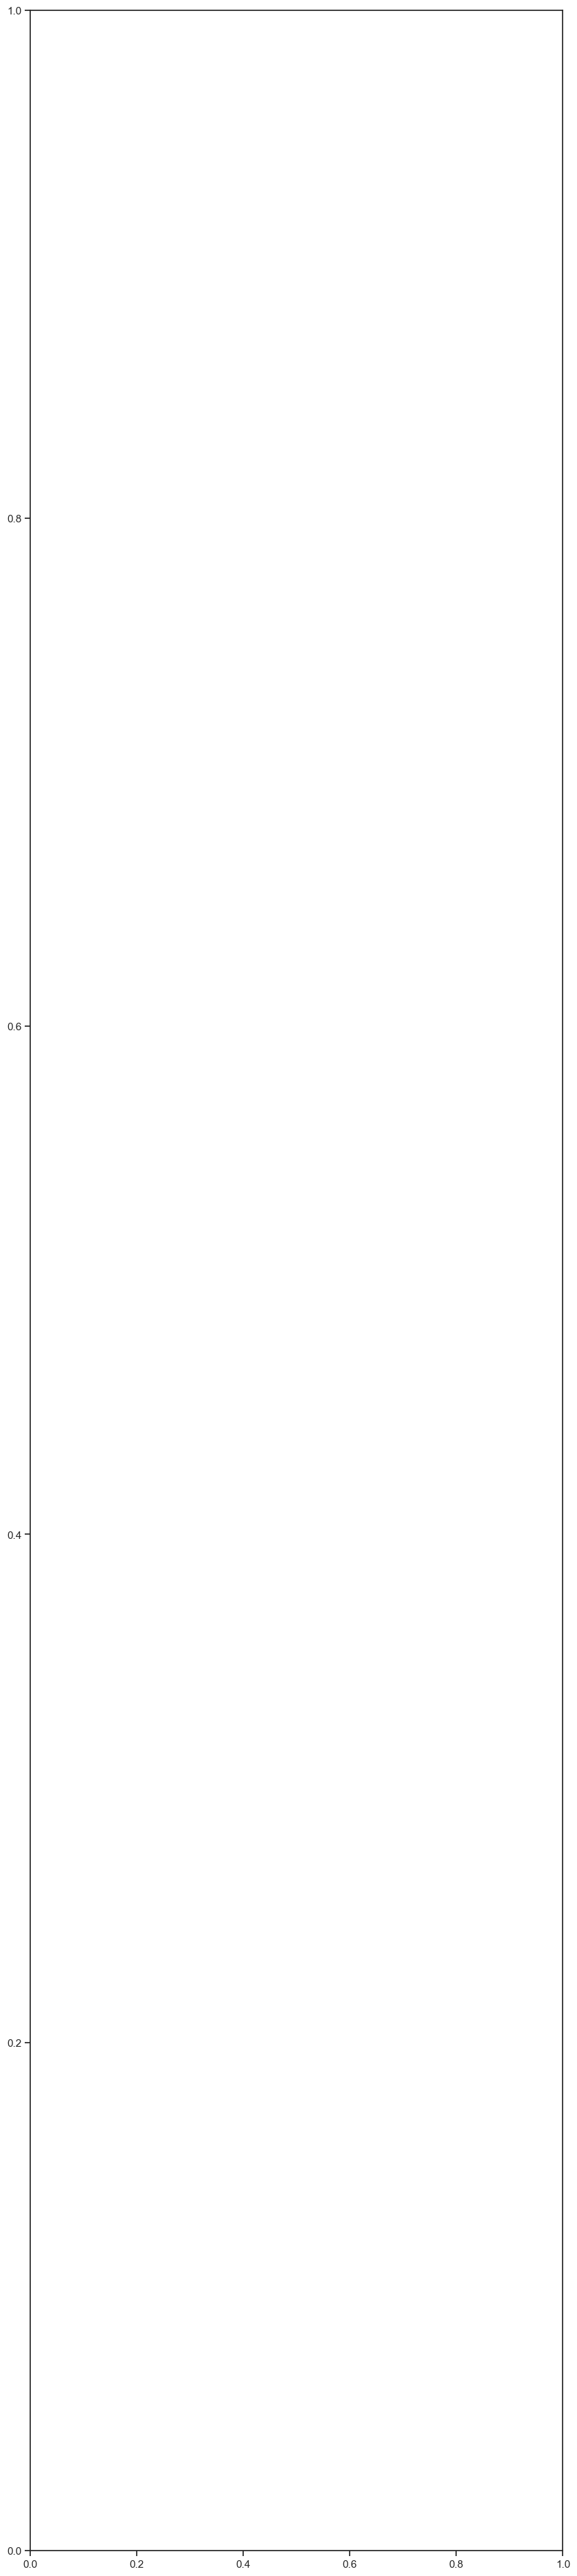

In [29]:
sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(10,48))
#ax.set_xscale("log", base=2)

sns.boxplot(flat_df, y="tf", x="GeneExpr",hue="tf", log_scale=2, order = order)


ax.xaxis.grid(True)
ax.set(ylabel="")
ax.axvline(1, dashes=(2, 2))
sns.despine(trim=True, left=True)
ax.set_xlabel("Gene Expression")
#fig.savefig("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Genexpression_All_TFBS.png")
plt.show

## Pearson Corr for all Tissues

### Generate Pearson Corr

In [8]:
def get_pearson(df):
    tfs = df.tf.unique()
    r_lst = []
    p_lst = []
    for tf in tfs:
        df_tf = df[df.tf == tf]
        r, p_value = pearsonr(df_tf.homotypic_count, df_tf.All_tissues)
        r_lst.append(r)
        p_lst.append(p_value)
    pearson_df = pd.DataFrame({"TFs":tfs, "Pearson_r":r_lst, "Pearson_p":p_lst})

    return pearson_df

In [47]:
pearson_df_old = get_pearson(flat_df)

C:\Users\julia\AppData\Local\Temp\ipykernel_712\2377506386.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p_value = pearsonr(df_tf["homotypic_count"], np.array(df_tf[tissue]))


In [73]:
pearson_df

NameError: name 'pearson_df' is not defined

In [15]:
#pearson_df.to_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_all_TFBS.csv", index=False)
flat_df

,chr,geneID,tf,close_tss,dist_tss,strand_orientation,homotypic_count,all_tfbs_count,all_tfbs_unique_count,GeneExpr,Tissue
0,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,0.691,Adipose - Subcutaneous
1,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,1.043,Adipose - Visceral (Omentum)
2,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,1.906,Adrenal Gland
3,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,1.397,Artery - Aorta
4,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,1.385,Artery - Coronary
...,...,...,...,...,...,...,...,...,...,...,...
37845841,chr7,ENSG00000128512.20,STAT5B,105,120,T,1,104,79,2.226,Testis
37845842,chr7,ENSG00000128512.20,STAT5B,105,120,T,1,104,79,7.504,Thyroid
37845843,chr7,ENSG00000128512.20,STAT5B,105,120,T,1,104,79,11.100,Uterus
37845844,chr7,ENSG00000128512.20,STAT5B,105,120,T,1,104,79,6.597,Vagina


In [18]:
occur_region = flat_df.groupby(["chr", "geneID", "tf", "homotypic_count", "Tissue"])["GeneExpr"].cumcount()

In [21]:
flat_df["occur"] = occur_region

In [26]:
flat_df_reduced = flat_df[flat_df["occur"] == 0]

In [27]:
pearson_df = get_pearson(flat_df_reduced)

C:\Users\julia\AppData\Local\Temp\ipykernel_712\2377506386.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p_value = pearsonr(df_tf["homotypic_count"], np.array(df_tf[tissue]))


In [28]:
pearson_df

,TFs,Pearson_r,Pearson_p
0,HMBOX1,0.003460,5.786607e-01
1,PKNOX1,-0.023021,1.708318e-15
2,NR2C2,0.000448,8.888255e-01
3,CLOCK,-0.053440,2.878528e-02
4,TP63,-0.006946,3.089315e-02
...,...,...,...
262,RXRB,NaN,NaN
263,KLF9,0.001433,4.180353e-01
264,BATF,0.066366,3.073679e-31
265,PLAG1,NaN,NaN


### Refine Correlation Data and Plot

#### Load Data and Refine

In [8]:
pearson_df = pd.read_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_all_TFBS.csv")

Sort DataFrame for Correlation, remove NANs, remove pvalues <0.05 and calculate -log10(p-value)

In [35]:
# Which TFBS have only one TFBS per Promotor?
na_r = pearson_df.Pearson_r.isna().to_numpy()
#pearson_df[na_r].TFs.to_numpy()


In [52]:
#pearson_df = pd.read_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_all_TFBS.csv")
pearson_df_sort = pearson_df.reindex(pearson_df["Pearson_r"].abs().sort_values(ascending=False).index).dropna()
pearson_df_sort_pval = pearson_df_sort[pearson_df_sort["Pearson_p"] < 0.05]
pearson_df_sort_pval["Pearson_p"] = -np.log10(pearson_df_sort_pval["Pearson_p"])
pearson_df_sort_pval

C:\Users\julia\AppData\Local\Temp\ipykernel_712\2549342215.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pearson_df_sort_pval["Pearson_p"] = -np.log10(pearson_df_sort_pval["Pearson_p"])


,TFs,Pearson_r,Pearson_p
248,TP73,0.089590,7.170988
237,ISL1,-0.077253,2.882795
29,TEAD1,0.075634,50.787410
264,BATF,0.066366,30.512341
161,RARG,-0.056595,2.937068
...,...,...,...
17,MAX,-0.004517,2.457863
214,SP2,0.004026,1.685013
128,TFAP2C,-0.003595,1.633336
156,SP1,0.003400,1.711588


In [37]:
# TFBS filterd out through p_value
filtered_tfbs = pearson_df_sort[pearson_df_sort["Pearson_p"] >= 0.05]
filtered_tfbs.TFs.to_numpy()

array(['MYOG', 'SIX1', 'HNF1B', 'BACH2', 'SMAD4', 'PHOX2B', 'MEIS1',
       'LEF1', 'NR2C1', 'MAF', 'HLF', 'RFX1', 'YY2', 'JUNB', 'T', 'GFI1B',
       'ONECUT1', 'MEF2A', 'LHX9', 'FOSL2', 'XBP1', 'ONECUT2', 'MAFB',
       'MYF5', 'IRF1', 'TCF7', 'SRF', 'ERF', 'DUX4', 'IRF4', 'MNT',
       'TAL1', 'GATA4', 'SNAI2', 'GRHL2', 'RFX5', 'GATA2', 'FOS', 'NRF1',
       'YY1', 'TFAP2A', 'FOXP1', 'HMBOX1', 'TP53', 'MEF2B', 'STAT1',
       'FOSL1', 'JUN', 'EOMES', 'GATA3', 'ETV4', 'CREM', 'NR2F1', 'CEBPG',
       'POU2F2', 'HNF4G', 'TWIST1', 'SIX2', 'NFIL3', 'ZNF143', 'REL',
       'SOX17', 'NR2F6', 'STAT2', 'GABPA', 'GATA6', 'KLF9', 'EBF3',
       'CTCF', 'MYB', 'ATF4', 'REST', 'EHF', 'TCF3', 'NR2C2', 'KLF4',
       'PAX5'], dtype=object)

Remove Entrys with p-value <0.05

In [33]:
pearson_df_sort_pval[pearson_df_sort_pval["Pearson_r"] < -0.05]

,TFs,Pearson_r,Pearson_p
237,ISL1,-0.077253,2.882795
161,RARG,-0.056595,2.937068
3,CLOCK,-0.053440,1.540830
135,NR1H4,-0.053097,1.563812
64,STAT5A,-0.051233,17.155926


#### Plot Pearson Correlation

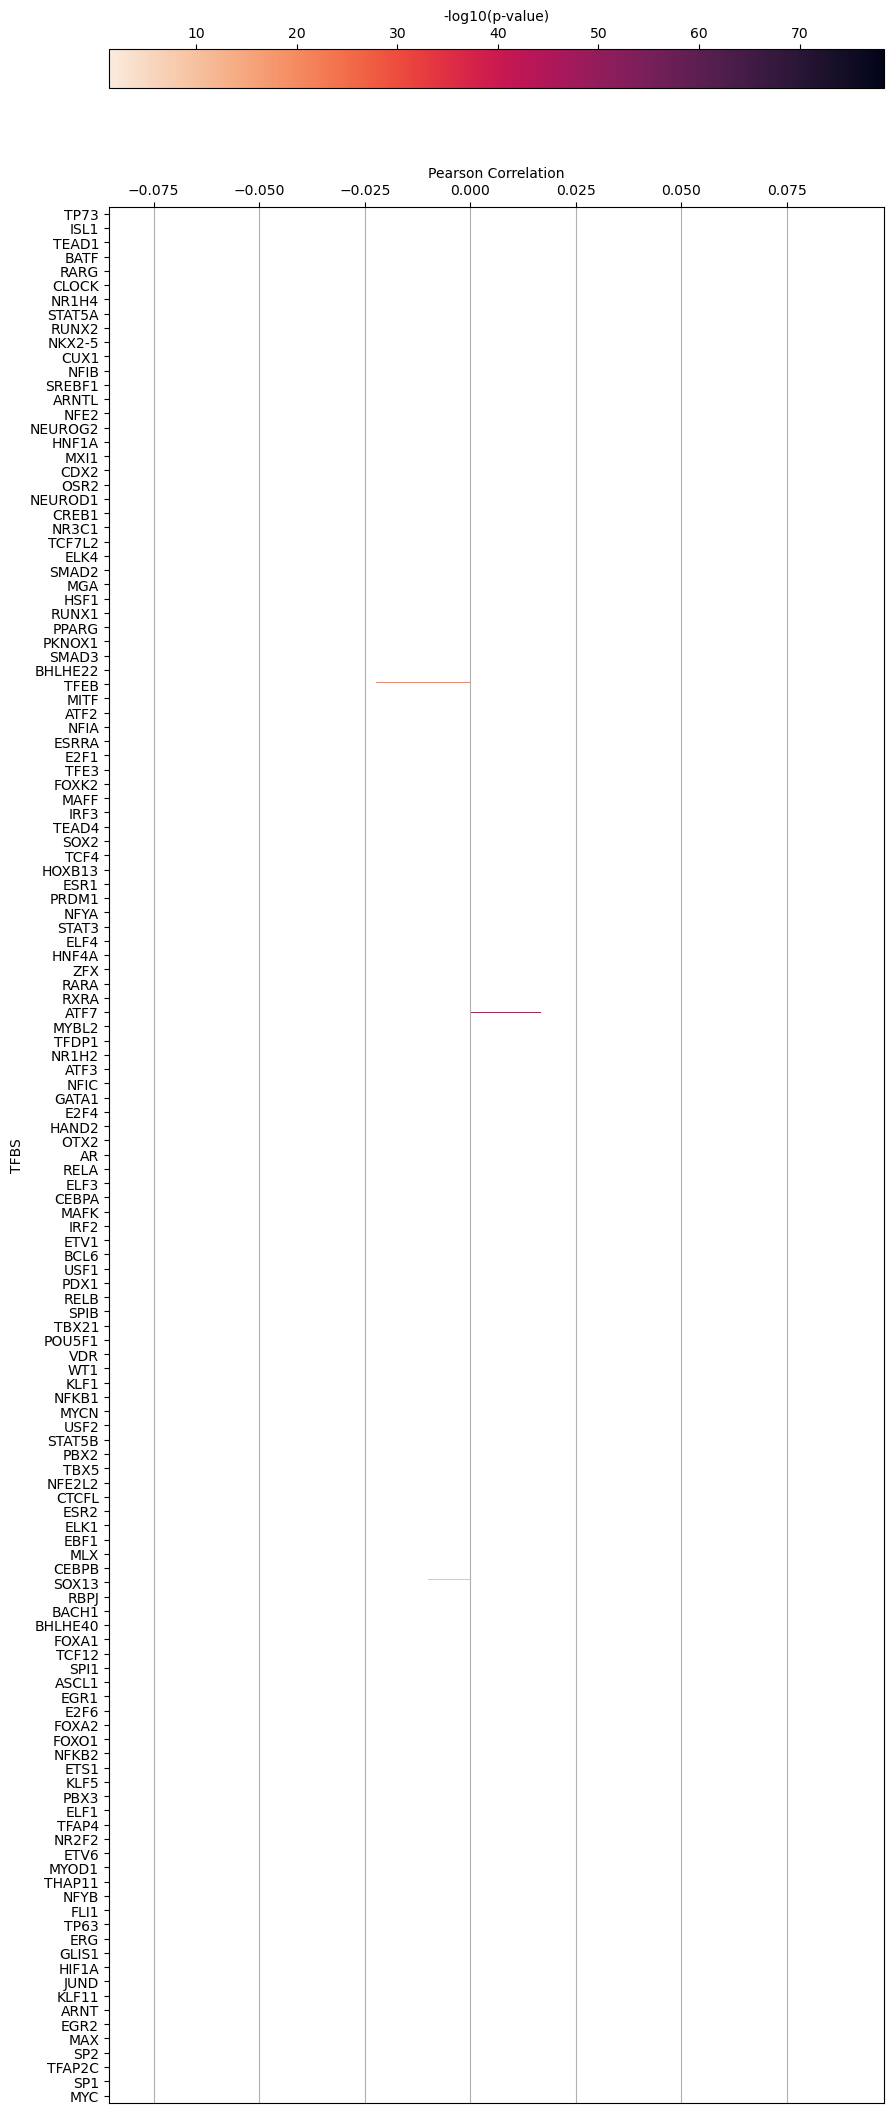

In [53]:
fig, ax = plt.subplots(figsize=(10,30))

norm = plt.Normalize(pearson_df_sort_pval["Pearson_p"].min(), pearson_df_sort_pval["Pearson_p"].max())
sm = plt.cm.ScalarMappable(cmap="rocket_r", norm=norm)

sns.barplot(pearson_df_sort_pval, x="Pearson_r", y="TFs",hue="Pearson_p", width=0.5, palette="rocket_r")


ax.set_ylabel('TFBS')

ax.xaxis.tick_top()
ax.set_xlabel('Pearson Correlation')
ax.xaxis.set_label_position("top")

ax.xaxis.grid(True)
ax.get_legend().remove()

plt.subplots_adjust(top=0.9)
cbar = ax.figure.colorbar(sm, ax=ax, orientation= "horizontal", location="top", )
cbar.set_label("-log10(p-value)")

#fig.savefig("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Boxplot/Pearson_corr_all_great_p.png")


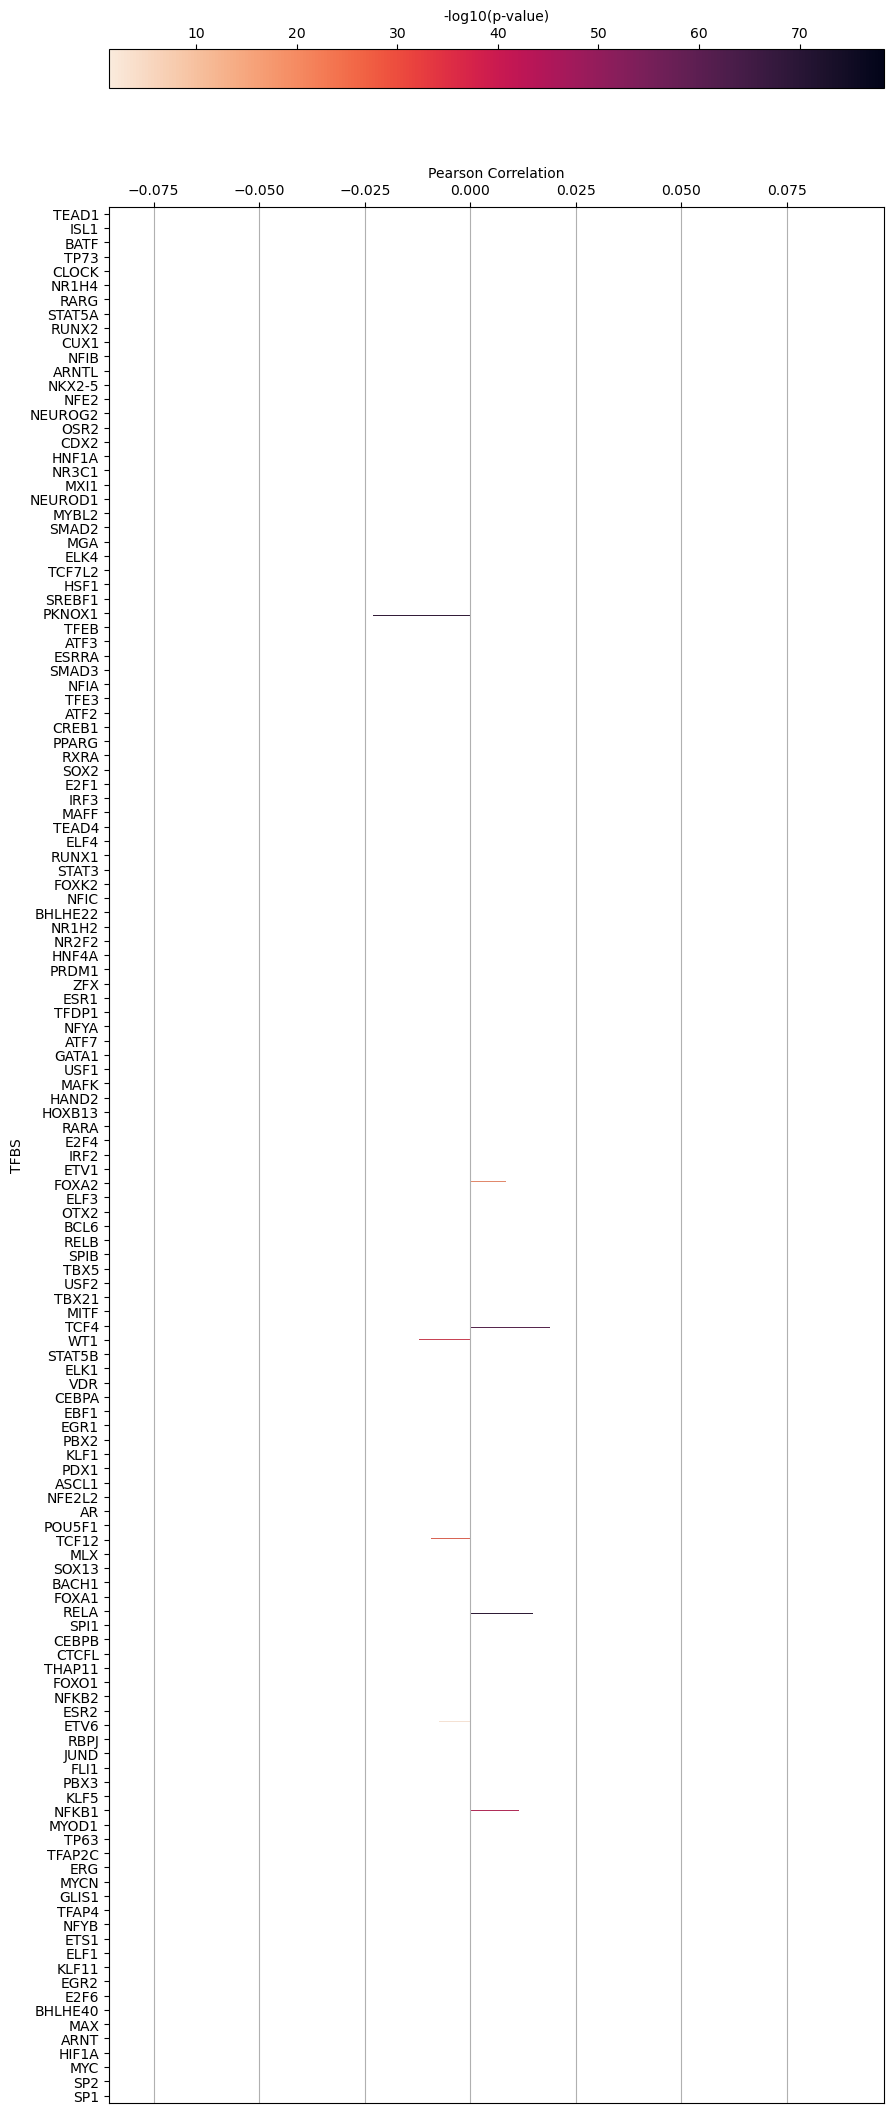

In [51]:
# For flat_df_reduced
fig, ax = plt.subplots(figsize=(10,30))

norm = plt.Normalize(pearson_df_sort_pval["Pearson_p"].min(), pearson_df_sort_pval["Pearson_p"].max())
sm = plt.cm.ScalarMappable(cmap="rocket_r", norm=norm)

sns.barplot(pearson_df_sort_pval, x="Pearson_r", y="TFs",hue="Pearson_p", width=0.5, palette="rocket_r")


ax.set_ylabel('TFBS')

ax.xaxis.tick_top()
ax.set_xlabel('Pearson Correlation')
ax.xaxis.set_label_position("top")

ax.xaxis.grid(True)
ax.get_legend().remove()

plt.subplots_adjust(top=0.9)
cbar = ax.figure.colorbar(sm, ax=ax, orientation= "horizontal", location="top", )
cbar.set_label("-log10(p-value)")

#fig.savefig("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Boxplot/Pearson_corr_all_great_p.png")

## Pearson Corr, different distance bins

### Split Data in different bins

In [7]:
flat_df

,chr,geneID,tf,close_tss,dist_tss,strand_orientation,homotypic_count,all_tfbs_count,all_tfbs_unique_count,All_tissues
0,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,0.691
1,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,1.043
2,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,1.906
3,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,1.397
4,chr1,ENSG00000163209.14,HMBOX1,159,169,nT,1,24,20,1.385
...,...,...,...,...,...,...,...,...,...,...
37849459,chr7,ENSG00000128512.20,STAT5B,105,120,T,1,104,79,2.226
37849460,chr7,ENSG00000128512.20,STAT5B,105,120,T,1,104,79,7.504
37849461,chr7,ENSG00000128512.20,STAT5B,105,120,T,1,104,79,11.100
37849462,chr7,ENSG00000128512.20,STAT5B,105,120,T,1,104,79,6.597


In [23]:
dist_avg = (np.array(flat_df["dist_tss"]) + np.array(flat_df["close_tss"]))/2

bin_1 = flat_df[dist_avg < 50]
bin_2 = flat_df[(dist_avg >= 50) & (dist_avg < 100)]
bin_3 = flat_df[(dist_avg >= 100) & (dist_avg < 150)]
bin_4 = flat_df[dist_avg > 150]

### Generate Pearson_correlation for every single Bin

In [26]:
pearson_df_bin_1 = get_pearson(bin_1)
#pearson_df_bin_1.to_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_bin_1_lower_50.csv", index=False)

/sybig/home/jme/Bachelorarbeit/.venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [27]:
pearson_df_bin_2 = get_pearson(bin_2)
pearson_df_bin_2.to_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_bin_2_50_100.csv", index=False)

In [28]:
pearson_df_bin_3 = get_pearson(bin_3)
pearson_df_bin_3.to_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_bin_3_100_150.csv", index=False)

In [29]:
pearson_df_bin_4 = get_pearson(bin_4)
pearson_df_bin_4.to_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_bin_4_greater_150.csv", index=False)

### Load Data and Plot all Bins

In [30]:
pearson_bin_1 = pd.read_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_bin_1_lower_50.csv")
pearson_bin_2 = pd.read_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_bin_2_50_100.csv")
pearson_bin_3 = pd.read_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_bin_3_100_150.csv")
pearson_bin_4 = pd.read_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_bin_4_greater_150.csv")

In [35]:
def refine_pearson_df(pearson_df):
    pearson_df_sort = pearson_df.reindex(pearson_df["Pearson_r"].abs().sort_values(ascending=False).index).dropna()
    pearson_df_sort_pval = pearson_df_sort[pearson_df_sort["Pearson_p"] < 0.05]
    pearson_df_sort_pval["Pearson_p"] = -np.log10(pearson_df_sort_pval["Pearson_p"])
    return pearson_df_sort_pval

In [58]:
p1 = refine_pearson_df(pearson_bin_1)
p2 = refine_pearson_df(pearson_bin_2)
p3 = refine_pearson_df(pearson_bin_3)
p4 = refine_pearson_df(pearson_bin_4)


/tmp/ipykernel_1227001/48341807.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pearson_df_sort_pval["Pearson_p"] = -np.log10(pearson_df_sort_pval["Pearson_p"])


##### Plot single Bin

In [ ]:
# Set Colorbar to min and max of all tfbs
min_p_value = min(p1["Pearson_p"].min(), p2["Pearson_p"].min(), p3["Pearson_p"].min(), p4["Pearson_p"].min())
max_p_value = max(p1["Pearson_p"].max(), p2["Pearson_p"].max(), p3["Pearson_p"].max(), p4["Pearson_p"].max())
#min_p_value = p4["Pearson_p"].min()
#max_p_value = p4["Pearson_p"].max()
norm = plt.Normalize(min_p_value, max_p_value)
sm = plt.cm.ScalarMappable(cmap="rocket_r", norm=norm)

# Plot all 4 plots 
fig, ax = plt.subplots(1, 4, figsize=(10,30))


sns.barplot(p4, x="Pearson_r", y="TFs",hue="Pearson_p", width=0.5, palette="rocket_r", hue_norm=norm)


ax.set_ylabel('TFBS')

ax.xaxis.tick_top()
ax.set_xlabel('Pearson Correlation')
ax.xaxis.set_label_position("top")

ax.xaxis.grid(True)
ax.get_legend().remove()

plt.subplots_adjust(top=0.9)
cbar = ax.figure.colorbar(sm, ax=ax, orientation= "horizontal", location="top", )
cbar.set_label("-log10(p-value)")

# fig.savefig("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Boxplot/Pearson_corr_all_bins.png")

##### Plot all bins

## Pearson Corr, all Tissues

In [141]:
df_combined["max_tissue_value"] = df_combined.iloc[:,9:].max(axis=1)

In [144]:
pearson_max_tissue = get_pearson(df_combined, tissue="max_tissue_value")
pearson_max_tissue.to_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_all_tfbs_max_tissue.csv", index=False)

/sybig/home/jme/Bachelorarbeit/.venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


NR5A1 has less then 2 entrys. No Correlation could be calculated


NameError: name 'pearson_df' is not defined

In [146]:
pearson_max_tissue = pd.read_csv()

## Pearson Corr, only #TFBS > 3

## Pearson Corr, only genes with similiar expr

In [11]:
pearson_similiar_expr = get_pearson(genes_with_similar_expression_flat)

/sybig/home/jme/Bachelorarbeit/.venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [12]:
pearson_similiar_expr.to_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_similiar_genexpr.csv", index=False)

In [ ]:
# pearson_similiar_expr = pd.read_csv("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Pearson_similiar_genexpr.csv")

In [25]:
pearson_similiar_expr_sort = pearson_similiar_expr.reindex(pearson_similiar_expr["Pearson_r"].abs().sort_values(ascending=False).index).dropna()
pearson_similiar_expr_pval = pearson_similiar_expr_sort[pearson_similiar_expr_sort["Pearson_p"] < 0.05]
#pearson_df_sort_pval["Pearson_p"] = -np.log10(pearson_df_sort_pval["Pearson_p"])
pearson_similiar_expr_pval_pearson_greater_01 = pearson_similiar_expr_pval[(pearson_similiar_expr_pval["Pearson_r"]>=0.1) | (pearson_similiar_expr_pval["Pearson_r"]<=-0.1)]
pearson_similiar_expr_pval_pearson_greater_01

,TFs,Pearson_r,Pearson_p
3,CLOCK,0.370797,8.400292e-28
192,CUX1,0.280415,2.534344e-93
135,NR1H4,-0.272316,2.113428e-13
6,PHOX2B,-0.231282,8.143141e-99
223,LHX9,0.225138,1.353411e-82
194,LEF1,0.219198,1.634578e-43
38,XBP1,0.199660,1.351529e-128
31,MAF,-0.176455,1.482932e-85
237,ISL1,-0.170092,1.615853e-09
230,ESRRA,0.147664,7.767865e-25


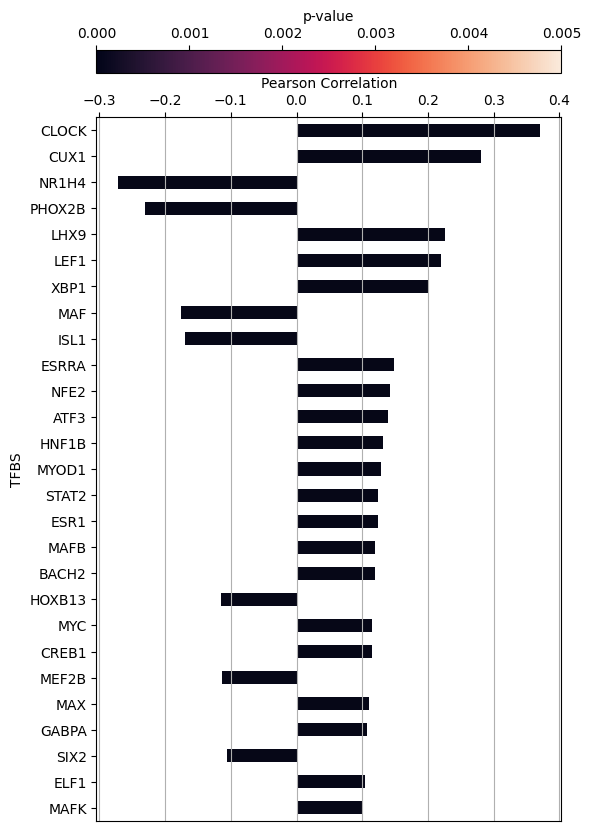

In [31]:
# Set Colorbar to min and max of all tfbs
#min_p_value = min(p1["Pearson_p"].min(), p2["Pearson_p"].min(), p3["Pearson_p"].min(), p4["Pearson_p"].min())
#max_p_value = max(p1["Pearson_p"].max(), p2["Pearson_p"].max(), p3["Pearson_p"].max(), p4["Pearson_p"].max())
min_p_value = pearson_similiar_expr_pval_pearson_greater_01["Pearson_p"].min()
max_p_value = pearson_similiar_expr_pval_pearson_greater_01["Pearson_p"].max()
norm = plt.Normalize(0, 0.005)
sm = plt.cm.ScalarMappable(cmap="rocket", norm=norm)

# Plot all 4 plots 
fig, ax = plt.subplots(figsize=(6,10))


sns.barplot(pearson_similiar_expr_pval_pearson_greater_01, x="Pearson_r", y="TFs",hue="Pearson_p", width=0.5, palette="rocket", hue_norm=norm)


ax.set_ylabel('TFBS')

ax.xaxis.tick_top()
ax.set_xlabel('Pearson Correlation')
ax.xaxis.set_label_position("top")

ax.xaxis.grid(True)
ax.get_legend().remove()

plt.subplots_adjust(top=0.99)
cbar = ax.figure.colorbar(sm, ax=ax, orientation= "horizontal", location="top", )
cbar.set_label("p-value")

#fig.savefig("/sybig/projects/GeneRegulation/data/jme/Bachelorarbeit/data/Single_TFBS/Boxplot/Pearson_corr_similiar_Expr_02.png")